### $H(z)$ from luminosity distance $D_L$
The ultimate goal is to be able to calculate the growth function, given by
$$ g(z) \equiv \frac{5\Omega_m}{2} \int_0^a \dfrac{da}{a^3H(a)^3}.$$
To do so we will obtain $H(z)$ from SNIa distance modulus measurements $\mu$. $\mu$ and $D_L$ are related by
$$\mu = 5\log D_L - 5,$$
and $D_L$ relates to the transverse comoving distance $D_M$ by
$$D_L = (1 + z)D_M $$
In a flat universe the transverse comoving distance $D_M$ is the same as the comoving distance $D_C$. From the Friedmann equation we know that
$$\dfrac{d D_C}{d z}=\dfrac{c}{H(z)}.$$
Therefore by getting $D_C$ from $D_L$ and differentiating $D_C$ we can solve for $H(z)$.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import scipy.interpolate as itp

%matplotlib inline

In [34]:
# plot style
import jupyterthemes.jtplot as jtplot
jtplot.reset()
plt.style.use('paper')

In [35]:
# reading data and assigning to a pandas dataframe
# name, redshift, distance modulus, distance modulus error
column_names = ['name', 'z', 'dm', 'dm_err']
udf = pd.read_csv('SCPUnion2.1_mu_vs_z.txt',sep ='\t', skiprows=5,header=None,usecols=[0,1,2,3],
                      names = column_names, index_col = 0)
# sorting by z
udf.sort_values('z', inplace=True)
# first 5 elements
udf.head()

,z,dm,dm_err
name,,,
1999aa,0.015000,34.163504,0.161453
2007s,0.015000,34.111411,0.213389
2006td,0.015000,34.379773,0.217349
2005bo,0.015027,33.950192,0.178117
2007ca,0.015100,34.525875,0.213682


In [36]:
udf.describe()

,z,dm,dm_err
count,580.000000,580.000000,580.000000
mean,0.361631,40.028495,0.222955
std,0.327353,3.195595,0.126012
min,0.015000,33.824609,0.084144
25%,0.054550,36.920249,0.151396
50%,0.294028,40.884198,0.189029
75%,0.551700,42.517637,0.241556
max,1.414000,45.410744,1.006812


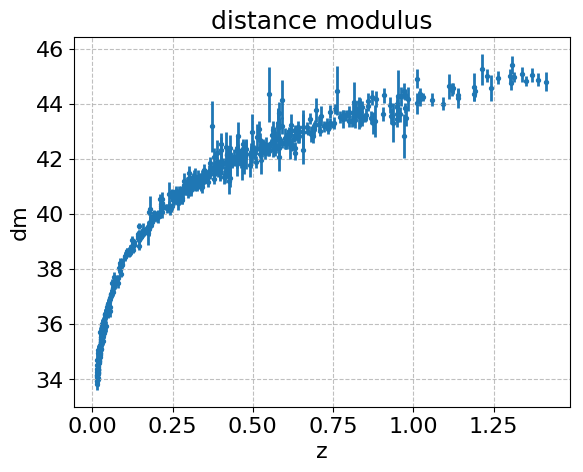

In [37]:
# distance modulus as a function of redshift with error bars
udf.plot.scatter(x='z',y='dm',yerr='dm_err', c='C0',s=8);
plt.title('distance modulus');
plt.show()

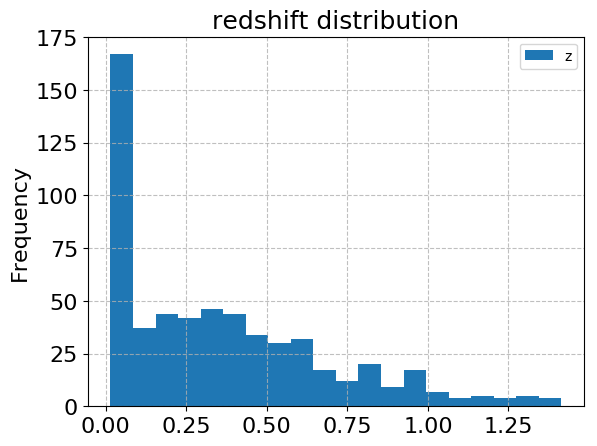

In [38]:
# redshift distribution
udf.plot.hist(y='z',bins=20);
plt.title('redshift distribution');

luminosity distance:
$$D_L = 10^{\, \mu/5 + 1}$$
$$\delta D_L = 2\cdot 10^{\mu/5}\log 10 \delta\mu $$


In [39]:
dl = 10**(udf.dm/5+1)
dl_err = 2 * 10**(udf.dm/5) * np.log(10) * udf.dm_err
udf['dl'],udf['dl_err'] = dl,dl_err

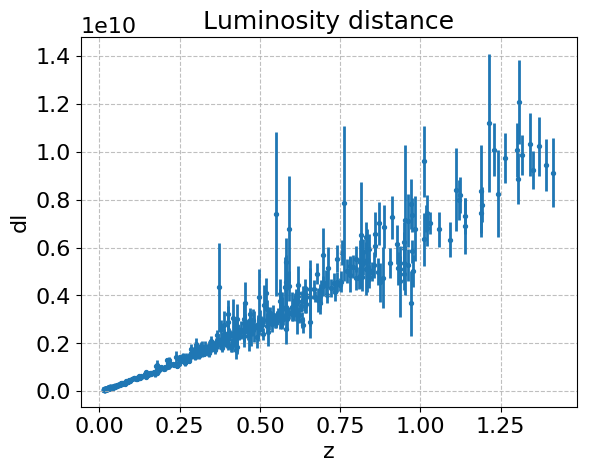

In [40]:
# luminosity distance by redshift with error bars
udf.plot.scatter(x='z',y='dl',yerr='dl_err',c='C0',s=8);
plt.title('Luminosity distance');

Comoving distance:
$$D_C = \dfrac{D_L}{1+z}$$
That's only true when $\Omega_k = 0$.

In [41]:
dc = udf.dl/(1+udf.z)
dc_err = udf.dl_err/(1+udf.z)
udf['dc'],udf['dc_err'] = dc,dc_err

In [26]:
udf.describe()

,z,dm,dm_err,dl,dl_err,dc,dc_err
count,580.000000,580.000000,580.000000,5.800000e+02,5.800000e+02,5.800000e+02,5.800000e+02
mean,0.361631,40.028495,0.222955,2.209307e+09,2.873946e+08,1.357102e+09,1.718642e+08
std,0.327353,3.195595,0.126012,2.317339e+09,4.345096e+08,1.150663e+09,2.363852e+08
min,0.015000,33.824609,0.084144,5.819984e+07,4.204643e+06,5.728331e+07,4.140726e+06
25%,0.054550,36.920249,0.151396,2.422198e+08,1.664568e+07,2.297995e+08,1.584158e+07
50%,0.294028,40.884198,0.189029,1.502674e+09,1.203920e+08,1.160148e+09,8.948252e+07
75%,0.551700,42.517637,0.241556,3.188077e+09,3.970816e+08,2.065195e+09,2.481783e+08
max,1.414000,45.410744,1.006812,1.208228e+10,3.426791e+09,5.237225e+09,2.210833e+09


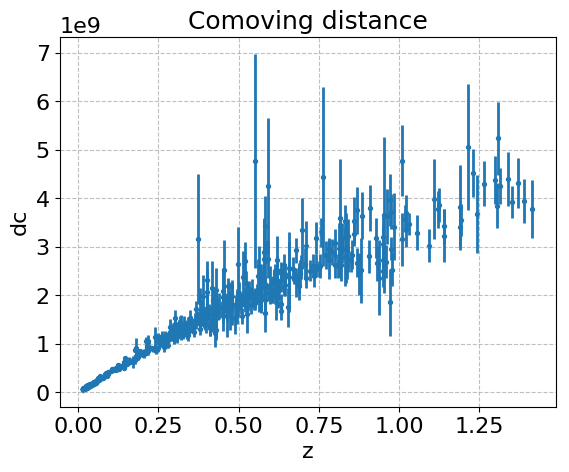

In [43]:
# comoving distance by redshift with error bars
udf.plot.scatter(x='z',y='dc',yerr='dc_err',c='C0',s=8);
plt.title('Comoving distance');

### Curve fits

In [46]:
# curve fit function: returns parameters, covariance matrix of parameters and chi2
def cfit(f,y):
    """f: function to use for fit;
    y: str, column to fit for; should have y_err in dataframe"""
    x, y, y_err = udf[['z',y,y+'_err']].values.T
    popt, pcov = opt.curve_fit(f, x, y, sigma=y_err)
    chi2 = np.sum((f(x,*popt) - y)**2/y_err**2)
    return popt, pcov, chi2

# curve fit plot: plot curve and labels with reduced chi2
def cf_plot(f, y, label=None):
    popt, pcov, chi2 = cfit(f,y)
    plt.plot(udf.z,f(udf.z, *popt), lw=2, 
             label=label+": chi2={}".format(np.round(chi2/len(udf),decimals=2)))

# fitting function to test

def p3(x,c0,c1,c2,c3):
    return c0 + c1*x + c2*x**2 + c3*x**3

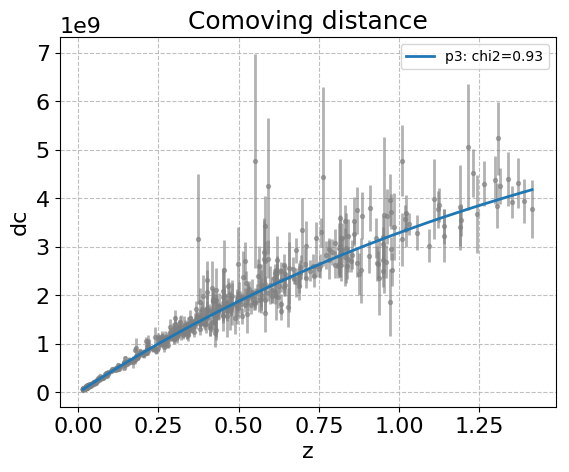

In [55]:
# plotting coming distance with three fitting functions
# labels show reduced chi square
udf.plot.scatter(x='z',y='dc',yerr='dc_err',c='Gray',alpha=0.6,s=8);
plt.title('Comoving distance');

cf_plot(p3,'dc', 'p3')

plt.legend()
plt.show()

### Interpolation
Not sure how error propagation should be done in this case

In [57]:
# x and y values to interpolate over
x = udf.z.values
y = udf.dc.values/udf.dc.max() #normalizing to facilitate smoothing

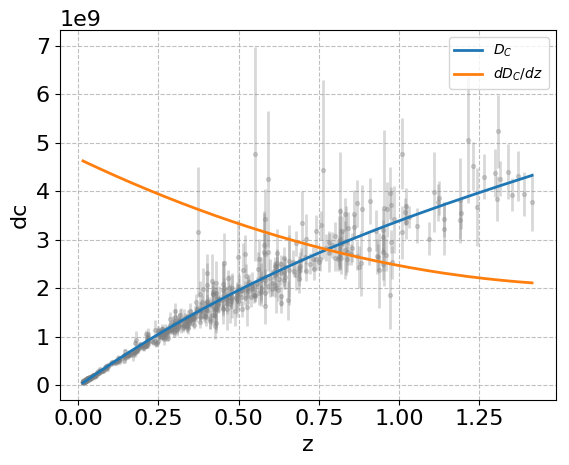

In [62]:
# fitting cubic spline, 's' is the smoothing parameter
spl = itp.UnivariateSpline(x,y,k=3,s=10)
# rescaling back
def dc_spl(x,i=0):
    return spl(x,i)*udf.dc.max()

#plotting
udf.plot.scatter(x='z',y='dc',yerr='dc_err',c='Gray',alpha=0.3,s=8);
plt.plot(x,dc_spl(x),lw=2, label=r"$D_C$")
plt.plot(x,dc_spl(x,1),lw=2, label=r"$d D_C/dz$")

plt.legend()
plt.show()

### H(z)

In [135]:
def hubble(dc_dz):
    """dc_dz: derivative of comoving distance w.r.t. redshift z"""
    c = 9.716*10**(-9) # speed of light in pc/s
    unitconv = 3.086*10**19 #to convert to km/s/Mpc
    return c*unitconv/(dc_dz)

In [136]:
# first derivative of cubic polynomial
def p3_dx(x,c0,c1,c2,c3):
    return c1 + 2*c2*x + 3*c3*x**2

$$(\sigma_f)^2 = \sum_{ij} \partial_i f \partial_j f C_{ij} = \sum_{ij} D_{ij} C_{ij}$$
where $C$ is the covariance matrix of the parameters of $f$.

In [137]:
# getting matrix D
def der_matrix(x):
    der = [0,1, 2*x, 3*x**2]
    return np.outer(der,der)
# getting uncertainty on function 
def der_err(x,cov):
    prod_matrix = der_matrix(x)*cov
    return np.sqrt(np.sum(prod_matrix))

# uncertainy on hubble parameter
def hubble_err(z,popt,pcov):
    c = 9.716*10**(-9) # speed of light in pc/s
    unitconv = 3.086*10**19 #to convert to km/s/Mpc
    return (c*der_err(z,pcov)*unitconv)/(p3_dx(z,*popt)**2)

In [138]:
#optimal parameters and cov matrix
popt, pcov = cfit(p3,'dc')[:-1]

In [139]:
# hubble in km/s/Mpc
h = hubble(p3_dx(udf.z,*popt))
h_err = [hubble_err(z,popt,pcov) for z in udf.z]
# insert columns in df
udf['h'], udf['h_err'] = h, h_err

In [140]:
udf.describe()

,z,dm,dm_err,dl,dl_err,dc,dc_err,h,h_err
count,580.000000,580.000000,580.000000,5.800000e+02,5.800000e+02,5.800000e+02,5.800000e+02,580.000000,580.000000
mean,0.361631,40.028495,0.222955,2.209307e+09,2.873946e+08,1.357102e+09,1.718642e+08,87.015636,1.996435
std,0.327353,3.195595,0.126012,2.317339e+09,4.345096e+08,1.150663e+09,2.363852e+08,18.051164,4.271727
min,0.015000,33.824609,0.084144,5.819984e+07,4.204643e+06,5.728331e+07,4.140726e+06,70.409095,0.354577
25%,0.054550,36.920249,0.151396,2.422198e+08,1.664568e+07,2.297995e+08,1.584158e+07,71.901133,0.592975
50%,0.294028,40.884198,0.189029,1.502674e+09,1.203920e+08,1.160148e+09,8.948252e+07,81.889013,0.723506
75%,0.551700,42.517637,0.241556,3.188077e+09,3.970816e+08,2.065195e+09,2.481783e+08,94.736350,1.314944
max,1.414000,45.410744,1.006812,1.208228e+10,3.426791e+09,5.237225e+09,2.210833e+09,159.008113,35.917367


In [217]:
# fiducial model - flat lcdm with no radiation
def h_lcdm(z,h0,om):
    return h0*np.sqrt(om*(1+z)**3 + (1-om))
# best-fit
lcdm_popt, lcdm_pcov = opt.curve_fit(h_lcdm, udf.z, udf.h, sigma=udf.h_err)
h_bf, om_bf = np.round(lcdm_popt,4)
h_bf_err, om_bf_err = np.round(np.sqrt(np.diag(lcdm_pcov)),4)

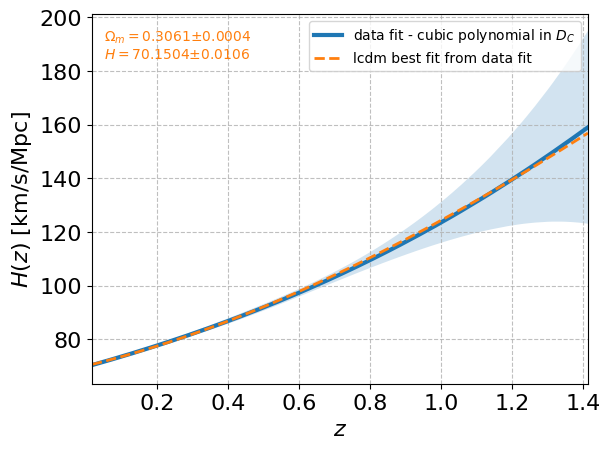

In [221]:
#plotting
udf.plot(x='z',y='h',c='C0', lw=3,
         alpha=1, label='data fit - cubic polynomial in $D_C$');
plt.fill_between(udf.z,udf.h+udf.h_err,udf.h-udf.h_err,
                 alpha=0.2)
plt.plot(udf.z,h_lcdm(udf.z, *lcdm_popt),
         c='C1',ls='dashed',
         label=r'lcdm best fit from data fit')

plt.text(0.05,185,
         '$\Omega_m = ${}$\pm${} \n$H = ${}$\pm${}'.format(
             om_bf,om_bf_err, h_bf, h_bf_err),
        color='C1')

plt.ylabel(r'$H(z)$ [km/s/Mpc]')
plt.xlabel(r'$z$')

plt.legend()
plt.show()